In [ ]:
pip install transformers

     |████████████████████████████████| 2.6 MB 7.2 MB/s 
     |████████████████████████████████| 636 kB 69.0 MB/s 
     |████████████████████████████████| 895 kB 74.7 MB/s 
     |████████████████████████████████| 3.3 MB 31.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import os
import re
import numpy as np
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from transformers import BertModel, BertConfig
from transformers import BertTokenizer

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# 시각화

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [ ]:
#random seed 고정
tf.random.set_seed(1234)
np.random.seed(1234)

# parameters
BATCH_SIZE = 32
NUM_EPOCHS = 3
VALID_SPLIT = 0.2
MAX_LEN = 150

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", cache_dir='bert_ckpt', do_lower_case=False)

## 토크나이저 테스트

In [ ]:
test_sentence = "안녕하세요, 반갑습니다."

encode = tokenizer.encode(test_sentence)
token_print = [tokenizer.decode(token) for token in encode]

print(encode)
print(token_print)

[101, 9521, 118741, 35506, 24982, 48549, 117, 9321, 118610, 119081, 48345, 119, 102]
['[ C L S ]', '안', '# # 녕', '# # 하', '# # 세', '# # 요', ',', '반', '# # 갑', '# # 습', '# # 니 다', '.', '[ S E P ]']


In [ ]:
kor_encode = tokenizer.encode("안녕하세요, 반갑습니다")
eng_encode = tokenizer.encode("Hello world")
kor_decode = tokenizer.decode(kor_encode)
eng_decode = tokenizer.decode(eng_encode)

print(kor_encode)
# [101, 9521, 118741, 35506, 24982, 48549, 117, 9321, 118610, 119081, 48345, 102]
print(eng_encode)
# [101, 31178, 11356, 102]
print(kor_decode)
# [CLS] 안녕하세요, 반갑습니다 [SEP]
print(eng_decode)
# [CLS] Hello world [SEP]

[101, 9521, 118741, 35506, 24982, 48549, 117, 9321, 118610, 119081, 48345, 102]
[101, 31178, 11356, 102]
[CLS] 안녕하세요, 반갑습니다 [SEP]
[CLS] Hello world [SEP]


# Korean Movie Review Classification

In [ ]:
#코랩 드라이브 연동
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# 데이터 전처리 준비
data_path = "/content/gdrive/MyDrive/참빛/integrated_data.csv"
data = pd.read_csv(data_path)
data.columns=['index','comments','sentiment','tokens']
token = data.iloc[:,:3]
token

,index,comments,sentiment
0,0,ㅋㅋㅋㅋㅋㅋㅋㅋㅋ 나도 왠지 원래 가격이 20만원이란 소리 아닌가 생각했는데 ㅋㅋㅋㅋㅋㅋ,0.0
1,1,이 분은 스트리트 푸드파이터에 나와야 했음 ㅋㅋㅋㅋㅋ,0.0
2,2,방송 편집 문제 임ㅜ,0.0
3,3,네 실제로 겪어봤는데 다르지 않습니다ㅎㅎ 착한 척은 한계가 분명 있음,0.0
4,4,그게 가식적인 이미지일지도 모름,0.0
...,...,...,...
20428,20428,피해자보다 가해자를 더 보호해주는 나라 여성의 피해에 굉장히 민감하신 우리의 ㅍㅁ나라,1.0
20429,20429,이성준 ㅋ 그럼 저 교수한테 왜 친일했냐고 물어봐 ㅂㅅ아 애초에 저 교수 과거 행적...,1.0
20430,20430,미나토 대깨문이다 ㄷㄷ,1.0
20431,20431,우파 승리 415 총선 무효 ㅋㅋㅋㅋㅋ 돈도 없고 늙기만 해서 아으 추해 늙는 것도...,1.0


In [ ]:
train_data = token.sample(frac=0.8, random_state=2021)
train_data = train_data.dropna()
temp = pd.concat([train_data, token])
test_data = temp.drop_duplicates(['index'], keep=False)
test_data = test_data.dropna()
print(len(train_data), len(test_data))

16346 4087


In [ ]:
'''
# 스페셜 토큰
print(tokenizer.all_special_tokens, "\n", tokenizer.all_special_ids)

# 토크나이저 테스트하기
kor_encode = tokenizer.encode("안녕하세요, 반갑습니다. ")
eng_encode = tokenizer.encode("Hello world")

kor_decode = tokenizer.decode(kor_encode)
eng_decode = tokenizer.decode(eng_encode)

print(kor_encode)
print(eng_encode)
print(kor_decode)
print(eng_decode)
'''

'\n# 스페셜 토큰\nprint(tokenizer.all_special_tokens, "\n", tokenizer.all_special_ids)\n\n# 토크나이저 테스트하기\nkor_encode = tokenizer.encode("안녕하세요, 반갑습니다. ")\neng_encode = tokenizer.encode("Hello world")\n\nkor_decode = tokenizer.decode(kor_encode)\neng_decode = tokenizer.decode(eng_encode)\n\nprint(kor_encode)\nprint(eng_encode)\nprint(kor_decode)\nprint(eng_decode)\n'

In [ ]:
# Bert Tokenizer

# 참조: https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus

def bert_tokenizer(sent, MAX_LEN):  
    encoded_dict = tokenizer.encode_plus(
        text = sent,
        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
        max_length = MAX_LEN,           # Pad & truncate all sentences.
        pad_to_max_length = True,
        return_attention_mask = True   # Construct attn. masks.        
    )
    
    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask'] # And its attention mask (simply differentiates padding from non-padding).
    token_type_id = encoded_dict['token_type_ids'] # differentiate two sentences
    
    return input_id, attention_mask, token_type_id

In [ ]:

input_ids = []
attention_masks = []
token_type_ids = []
train_data_sentis = []

for train_com, train_senti in tqdm(zip(train_data["comments"], train_data["sentiment"]), total=len(train_data)):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(train_com, MAX_LEN)
        
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        train_data_sentis.append(train_senti)

    except Exception as e:
        print(e)
        print(train_com)
        pass

train_input_ids = np.array(input_ids, dtype=int)
train_attention_masks = np.array(attention_masks, dtype=int)
train_type_ids = np.array(token_type_ids, dtype=int)
train_inputs = (train_input_ids, train_attention_masks, train_type_ids)

train_data_sentis = np.asarray(train_data_sentis, dtype=np.int32) #레이블 토크나이징 리스트

print("# comments: {}, # sentiment: {}".format(len(train_input_ids), len(train_data_sentis)))

  0%|          | 0/16346 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 16346/16346 [00:05<00:00, 2789.73it/s]


# comments: 16346, # sentiment: 16346


In [ ]:
# 최대 길이: 
input_id = train_input_ids[1]
attention_mask = train_attention_masks[1]
token_type_id = train_type_ids[1]

print(input_id)
print(attention_mask)
print(token_type_id)
print(tokenizer.decode(input_id))

[   101    100    100   9260  41919   9303  12508   9303  12508   9420
  66540  19105  80564  11287   9748   8942  16985  12424  71568  11287
   9364  41850  19709  64002   9565 119294 101450   9949  48549  11287
   9555  12965   9710    100    102      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      

In [ ]:
class TFBertClassifier(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):
        super(TFBertClassifier, self).__init__()

        self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        self.classifier = tf.keras.layers.Dense(num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range), 
                                                name="classifier")
        
    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
        
        #outputs 값: # sequence_output, pooled_output, (hidden_states), (attentions)
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1] 
        pooled_output = self.dropout(pooled_output, training=training)
        logits = self.classifier(pooled_output)

        return logits

In [ ]:
from transformers import BertModel, TFBertModel

cls_model = TFBertClassifier(model_name='bert-base-multilingual-cased',
                                  dir_path='bert_ckpt',
                                  num_class=2)

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# 학습 준비하기 -metric accuracy
optimizer = tf.keras.optimizers.Adam(3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
model_name = "bert_model_64_ep3"

# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy',min_delta=0.0001,patience=2)

# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

data_out_path = '/content/gdrive/MyDrive/참빛'
checkpoint_path = os.path.join(data_out_path, model_name, 'bert_model_ep3.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

#checkpoint 저장
#cls_model.save_weights(checkpoint_path.format(epoch=0))

# 학습과 eval 시작
history = cls_model.fit(train_inputs, train_data_sentis, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
                    validation_split = VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

#steps_for_epoch
print(history.history)

/content/gdrive/MyDrive/참빛/bert_model_64_ep3 -- Folder already exists 

Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not 

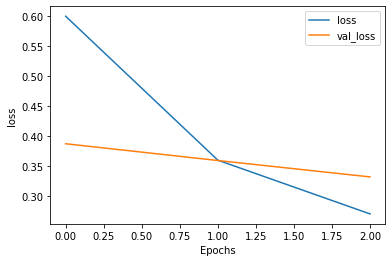

In [ ]:
plot_graphs(history, 'loss')

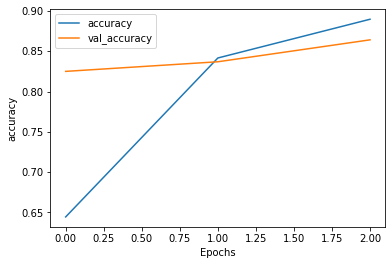

In [ ]:
plot_graphs(history, 'accuracy')

# Korean Movie Review Test 데이터

In [ ]:
test_data.head()

,index,comments,sentiment
4,4,그게 가식적인 이미지일지도 모름,0.0
14,14,송지효 상자 속 물건 맞추기 할 때 해주세요 ㅠㅠ 그거 진짜 보고 싶은데 영상도 없...,0.0
31,31,김지원 천진난만하게 웃는 거 너무 귀엽네,0.0
41,41,타팬이 봐도 이 특 너무 예쁘다,0.0
52,52,옛날이 진짜진짜 재밌었는데 ㅠㅠ 하,0.0


In [ ]:
input_ids = []
attention_masks = []
token_type_ids = []
test_data_sentis = []

for test_com, test_senti in tqdm(zip(test_data["comments"], test_data["sentiment"]), total=len(test_data)):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(test_com, MAX_LEN)
        
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        test_data_sentis.append(test_senti)

    except Exception as e:
        print(e)
        print(test_com)
        pass

test_input_ids = np.array(input_ids, dtype=int)
test_attention_masks = np.array(attention_masks, dtype=int)
test_type_ids = np.array(token_type_ids, dtype=int)
test_inputs = (test_input_ids, test_attention_masks, test_type_ids)

test_data_sentis = np.asarray(test_data_sentis, dtype=np.int32) #레이블 토크나이징 리스트

print("# comments: {}, # sentiment: {}".format(len(test_input_ids), len(test_data_sentis)))

  0%|          | 0/4087 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 4087/4087 [00:01<00:00, 2890.30it/s]


# comments: 4087, # sentiment: 4087


In [ ]:
results = cls_model.evaluate(test_inputs, test_data_sentis)
print("test loss, test acc: ", results)

128/128 [==============================] - 42s 330ms/step - loss: 0.3652 - accuracy: 0.8449
test loss, test acc:  [0.3652498722076416, 0.8448739647865295]
